In [1]:
#Following code processed data into
#4 parameters
#1. peak force or amplitude
#2. frequency or contractions/hour (via graphs)
#3. duration of contractions
#4. relaxation time

In [1]:
#packages

#import python packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.signal import peak_widths
import peakutils

In [2]:
#assigning filename handles to filenames

#assign filename variable
#example input: 2018_08_24_Myometrial_Contractility_Study_5_MB_1_8.tsv
filename = input("Input filename:" )
#assign variable for excel reference file
ref_filename = "./Myometrial Contractility Reference.txt"
#assign variable for comments file
comments_filename = filename[0:-4] + "_comments" + ".txt"

Input filename:2018_08_24_Myometrial_Contractility_Study_5_MB_1_8.tsv


In [3]:
#importing files and processing

#import muscle bath tsv file
df_file = pd.read_csv(filename, sep='\t')
#import data from excel reference file
df_ref = pd.read_csv(ref_filename, sep='\t')
#import corresponding comments file
comments_file = open(comments_filename,'r')
#process comments
cment_time = []
cment_txt = []
for line in comments_file:
    line = line.rstrip()
    line = line.split(sep = '\t')
    cment_time.append(line[0])
    cment_txt.append(line[1])
#drop unneccessary columns from muscle bath force file
df_file = df_file.drop(columns=['Timestamp','Stimulus'])
#set experiment time as index
df_file.set_index('Experiment Time', inplace = True)
#find filename in reference dataframe
df_ref = df_ref[df_ref['Filename'] == filename]
#drop extra columns
df_ref = df_ref[df_ref.columns[0:14]]
#check to see if muscle bundle should be excluded
df_ref = df_ref[df_ref["EXCLUDE SAMPLE"] != 1]
#reset df_ref index, starting at 0
#this enables easier indexing
df_ref.set_index([pd.Index(list(range(len(df_ref))))])

,Filename,Study,Patient,Bath Number,Patient Status,Pitocin,Amount (ml),Treatment,Conc. (ng/ml),Length (mm),Width1(mm),Width2(mm),Mass (mg),EXCLUDE SAMPLE
0,2018_08_24_Myometrial_Contractility_Study_5_MB...,5,RJ6,1,NaN,1.0,0.1,Adiponectin,100.0,37.42,1.77,1.98,103.0,NaN
1,2018_08_24_Myometrial_Contractility_Study_5_MB...,5,RJ6,2,NaN,0.0,0.0,Adiponectin,100.0,18.92,2.82,1.68,54.0,NaN
2,2018_08_24_Myometrial_Contractility_Study_5_MB...,5,RJ6,3,NaN,1.0,0.1,TNF_alpha,10.0,15.30,2.60,2.24,63.0,NaN
3,2018_08_24_Myometrial_Contractility_Study_5_MB...,5,RJ6,4,NaN,0.0,0.0,TNF_alpha,10.0,25.72,1.45,1.99,57.0,NaN
4,2018_08_24_Myometrial_Contractility_Study_5_MB...,5,RJ6,5,NaN,1.0,0.1,TNF_alpha,10.0,16.97,2.14,1.75,42.0,NaN
5,2018_08_24_Myometrial_Contractility_Study_5_MB...,5,RJ6,6,NaN,0.0,0.0,Adiponectin,2000.0,17.72,1.31,1.04,21.0,NaN
6,2018_08_24_Myometrial_Contractility_Study_5_MB...,5,RJ6,7,NaN,1.0,0.1,Control,NaN,14.09,2.14,1.94,32.0,NaN
7,2018_08_24_Myometrial_Contractility_Study_5_MB...,5,RJ6,8,NaN,0.0,0.0,Control,NaN,24.22,2.17,2.32,104.0,NaN


In [52]:
#Determining when baseline ends and treatment begins

#print comments with timepoints
for counter, value in enumerate(cment_time):
    print(cment_txt[counter],":",value)
#create a list of the column names where muscle bath force values are stored
Force_list = ["Force1","Force2","Force3","Force4","Force5","Force6","Force7","Force8"]
#create a placeholder list for storing arrays of force data
baseline_array_list = []
#loop through viable muscle baths in study file (df_file) and retrieve baseline force data
#send array of each muscle bath baseline force data to baseline_array_list
#also create a placeholder list for treatment starttime to be later used in treatment peak analysis
treat_time_list = []
count = 0
for bath in df_ref['Bath Number']:
    print('Muscle Bath',bath,':')
    baseline_endtime = int(float(input("What time is treatment added?")))
    if bath < 9:
        baseline_array = (df_file.loc[baseline_endtime-3599:baseline_endtime,Force_list[bath-1]])
        #baseline_array = (df_file.loc[baseline_endtime-3899:baseline_endtime+300,Force_list[bath-1]])
    elif bath > 16:
        baseline_array = (df_file.loc[baseline_endtime-3599:baseline_endtime,Force_list[bath-17]])
    else:
        baseline_array = (df_file.loc[baseline_endtime-3599:baseline_endtime,Force_list[bath-9]])
    baseline_array_list.append(baseline_array)
    treat_time_list.append(baseline_endtime)
    count += 1

Pitocin : 7205.6
Baseline : 10948.3
Treatment Bath 1 : 14799.0
Treatment Bath 2 : 14822.8
Treatment Bath 3 : 14931.2
Treatment Bath 4 : 14969.3
Treatment Bath 5 : 14994.1
Treatment Bath 6 : 15033.7
Treatment Bath 7 : 15052.7
Treatment Bath 8 : 15055.2
Muscle Bath 1 :
What time is treatment added?14799.0
Muscle Bath 2 :
What time is treatment added?14822.8
Muscle Bath 3 :
What time is treatment added?14931.2
Muscle Bath 4 :
What time is treatment added?14931.2
Muscle Bath 5 :
What time is treatment added?14994.1
Muscle Bath 6 :
What time is treatment added?15033.7
Muscle Bath 7 :
What time is treatment added?15052.7
Muscle Bath 8 :
What time is treatment added?15055.2


In [53]:
peak_rel_height = 1.0
rel_height = 0.80

# 1 HOUR BASELINE


#### Baseline Graphs

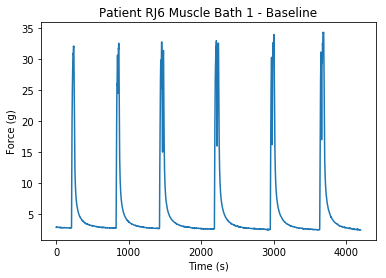

patientRJ6_bath1_baseline.pdf


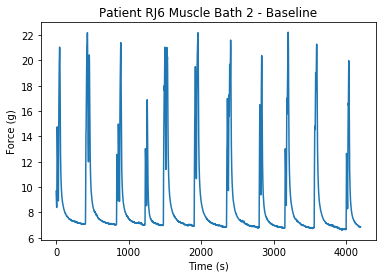

patientRJ6_bath2_baseline.pdf


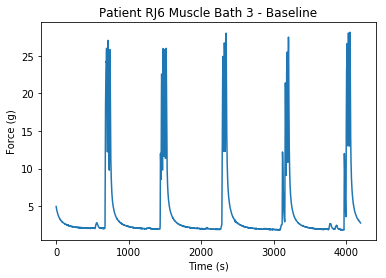

patientRJ6_bath3_baseline.pdf


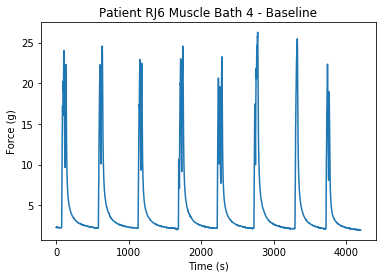

patientRJ6_bath4_baseline.pdf


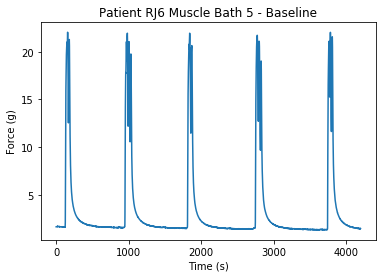

patientRJ6_bath5_baseline.pdf


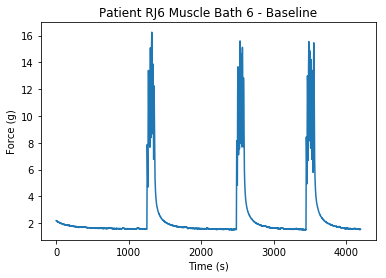

patientRJ6_bath6_baseline.pdf


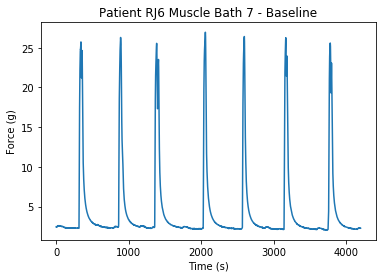

patientRJ6_bath7_baseline.pdf


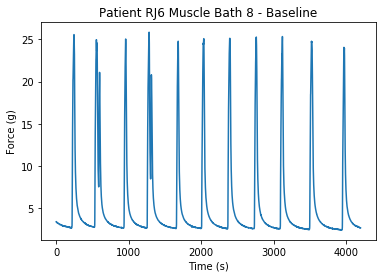

patientRJ6_bath8_baseline.pdf


In [54]:
##### Graphs for 1 hour baseline

#plot the baseline contraction force data from
#for bath in df_ref['Bath Number']:
for i in range(len(baseline_array_list)):        
    bath = df_ref.iloc[i]["Bath Number"]
    f = plt.figure()
    plt.plot(np.array(baseline_array_list[i]))
    plt.title("Patient "+list(df_ref['Patient'])[i]+" Muscle Bath "+str(bath)+" - Baseline")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    plt.show()
    #save baseline plots as pdf file
    savestring = "patient"+(list(df_ref['Patient'])[i])+"_"+"bath"+str(bath)+"_baseline"+'.pdf'
    print(savestring)
    f.savefig('baseline_graphs/'+savestring,sep = '')

#### Offset Baseline Force to 0g

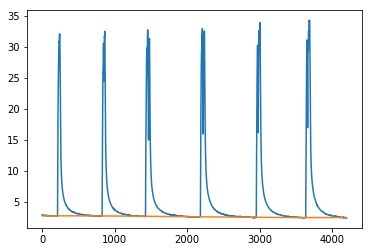

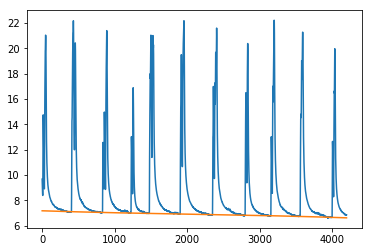

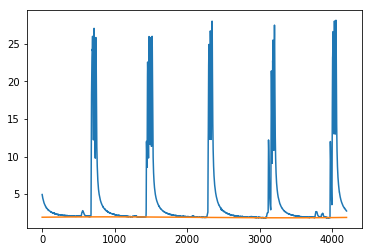

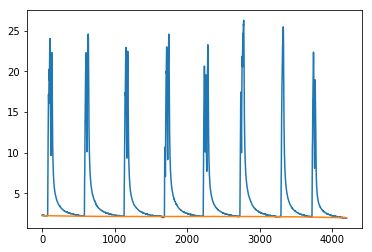

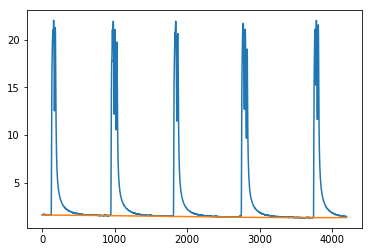

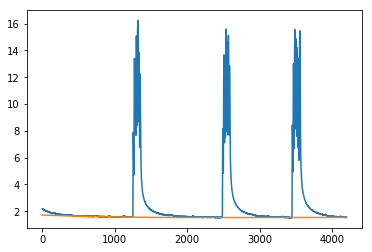

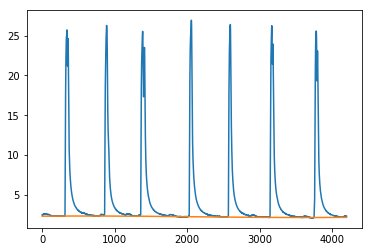

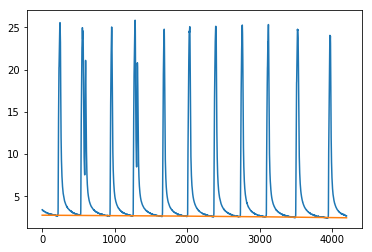

In [55]:
#plot muscle bath baseline contractions; overlay baseline/passive tension
for mb in range(len(baseline_array_list)):
    baseline_array_list[mb] = (np.array(baseline_array_list[mb]))
    plt.plot((baseline_array_list[mb]))
    plt.plot(peakutils.baseline(np.array(baseline_array_list[mb])))
    plt.show()

In [56]:
type(baseline_array_list)

list

In [57]:
type(baseline_array_list[0])

numpy.ndarray

In [58]:
len(baseline_array_list[0])

4200

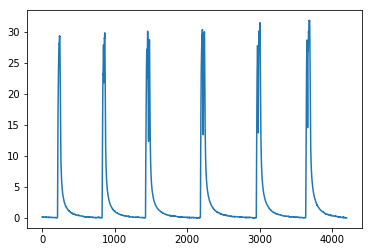

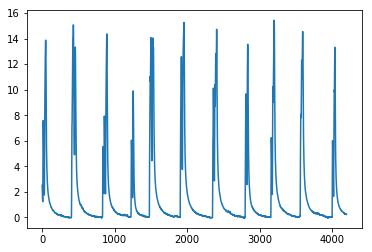

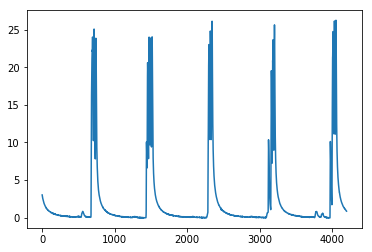

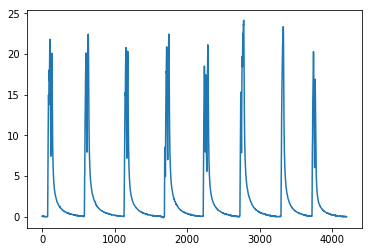

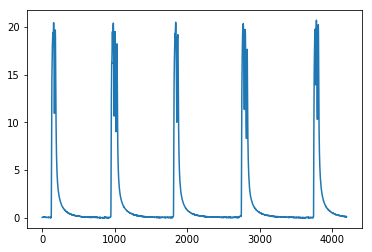

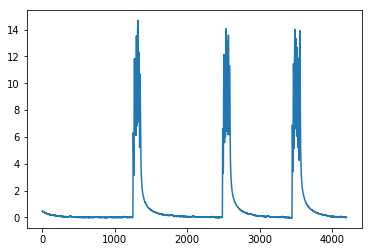

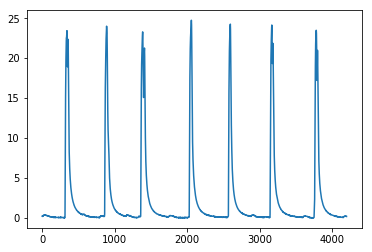

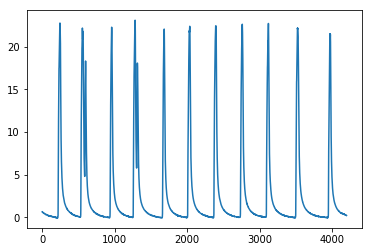

In [59]:
for mb in range(len(baseline_array_list)):
    baseline_array_list[mb] = baseline_array_list[mb] - peakutils.baseline(np.array(baseline_array_list[mb]))
    plt.plot(baseline_array_list[mb])
    plt.show()

In [60]:
#clip values below 0 
for mb in range(len(baseline_array_list)):
    baseline_array_list[mb] = baseline_array_list[mb].clip(min=0)
    print(baseline_array_list[mb])

[0.09023472 0.08919329 0.09615202 ... 0.         0.         0.        ]
[2.50007221 2.2372634  2.01045449 ... 0.22226391 0.24046325 0.23866267]
[3.01684286 2.94871056 2.88157846 ... 0.91557607 0.89044282 0.86130937]
[0.04345208 0.04863727 0.02782226 ... 0.         0.         0.        ]
[0.02213266 0.0241743  0.03221602 ... 0.09561259 0.09256721 0.10952172]
[0.46978408 0.45898926 0.46719429 ... 0.01211345 0.01413088 0.01314836]
[0.16853489 0.16044568 0.15235664 ... 0.13118091 0.13109506 0.13200903]
[0.63537101 0.62641909 0.62346717 ... 0.22709565 0.22321071 0.2153258 ]


#### Process Edges

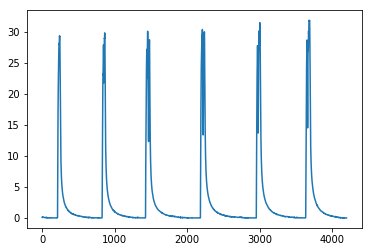

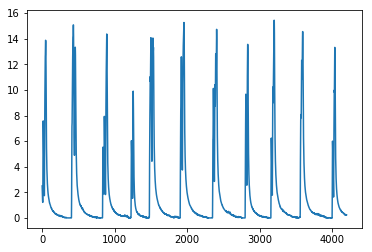

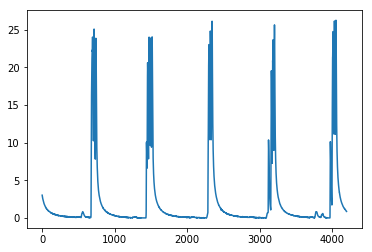

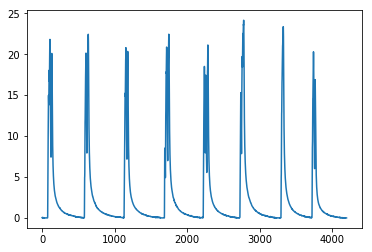

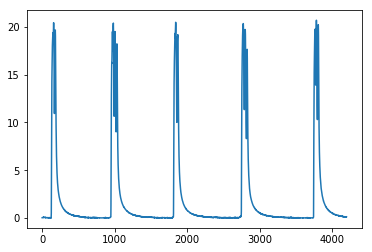

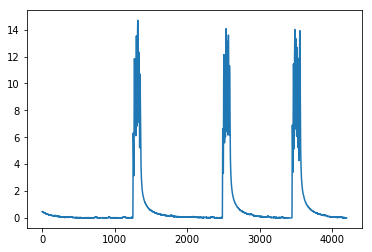

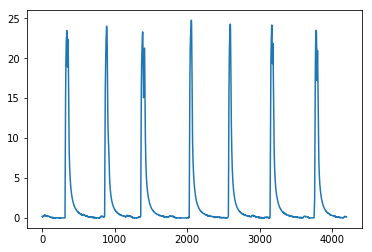

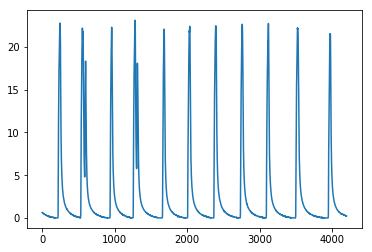

In [61]:
#baseline_array_list[1][-1] = 0


for mb in range(len(baseline_array_list)):
    plt.plot(baseline_array_list[mb])
    plt.show()

#### Peak Detection 

In [62]:
baseline_width_var = 5

In [63]:
#loop through muscle baths in reference dataframe 
    #for each bath listed in the reference file, find the local max 
    #for the 1 hr of baseline in the muscle bath file
    #ask when baseline ended for each bath and count backwords 1hr
#create storage lists for outputs
locmax_list = []
fp_output_list = []
#for loop for peak analysis
#vary width variable for each study to tune the find_peaks function
#width_var = float(input("input the width variable for find_peaks function:"))
for i in range(len(baseline_array_list)):           
    bath = df_ref.iloc[i]["Bath Number"]
    #print("Muscle Bath",bath,":")
    #input the height cut off for peak analysis
    #print 90% peak level
    #commented out for automatic peak cutoff input:
    #print("25% of peak",max(baseline_array_list[i]) - ((max(baseline_array_list[i])-min(baseline_array_list[i]))*.75))
    #cutoff = float(input("input peak height cutoff:"))
    #automatic calculation of peak cutoff
    peak25 = max(baseline_array_list[i]) - ((max(baseline_array_list[i])-min(baseline_array_list[i]))*.75)
    cutoff = float(peak25)
    #vary width variable for each study to tune the find_peaks function
    #comment out width_var unless need to vary width for each bath
    #width_var = float(input("input the width variable for find_peaks function:"))
    fp_output = find_peaks(np.array(baseline_array_list[(i)]),height = cutoff, width = baseline_width_var, distance = 100)
    
    
    
    
    locmax = np.array(baseline_array_list[(i)])[fp_output[0]]
    locmax_list.append(locmax)
    fp_output_list.append(fp_output)
    print(fp_output)
    #print("\n")
    
#width variable used for analysis of each study: 






(array([ 242,  863, 1455, 2210, 3003, 3684], dtype=int64), {'peak_heights': array([29.29567691, 29.80647699, 30.06972735, 30.34899932, 31.44445635,
       31.84201442]), 'prominences': array([29.29567691, 29.80647699, 30.06972735, 30.34899932, 31.44445635,
       31.84201442]), 'left_bases': array([ 211,  826, 1425, 2182, 2954, 3634], dtype=int64), 'right_bases': array([ 711, 1357, 1907, 2801, 3546, 4166], dtype=int64), 'widths': array([34.82546406, 39.18177351, 33.12157174, 30.26561455, 33.95849741,
       36.75211503]), 'width_heights': array([14.64783846, 14.9032385 , 15.03486367, 15.17449966, 15.72222817,
       15.92100721]), 'left_ips': array([ 217.84452934,  833.31359046, 1432.13282198, 2189.25643603,
       2981.38813464, 3663.03511594]), 'right_ips': array([ 252.6699934 ,  872.49536397, 1465.25439372, 2219.52205058,
       3015.34663204, 3699.78723097])})
(array([  47,  430,  891, 1256, 1500, 1956, 2407, 2836, 3201, 3594, 4037],
      dtype=int64), {'peak_heights': array([13.8

In [66]:
fp_output_list[0]

(array([ 242,  863, 1455, 2210, 3003, 3684], dtype=int64),
 {'left_bases': array([ 211,  826, 1425, 2182, 2954, 3634], dtype=int64),
  'left_ips': array([ 217.84452934,  833.31359046, 1432.13282198, 2189.25643603,
         2981.38813464, 3663.03511594]),
  'peak_heights': array([29.29567691, 29.80647699, 30.06972735, 30.34899932, 31.44445635,
         31.84201442]),
  'prominences': array([29.29567691, 29.80647699, 30.06972735, 30.34899932, 31.44445635,
         31.84201442]),
  'right_bases': array([ 711, 1357, 1907, 2801, 3546, 4166], dtype=int64),
  'right_ips': array([ 252.6699934 ,  872.49536397, 1465.25439372, 2219.52205058,
         3015.34663204, 3699.78723097]),
  'width_heights': array([14.64783846, 14.9032385 , 15.03486367, 15.17449966, 15.72222817,
         15.92100721]),
  'widths': array([34.82546406, 39.18177351, 33.12157174, 30.26561455, 33.95849741,
         36.75211503])})

In [48]:
# processing find_peaks output
#assigning values from find peaks output to a list of local max indices 
locmax_indx_list = []
for i in range(len(fp_output_list)):
    locmax_indx_list.append(fp_output_list[i][0])
#assigning values from find peaks dictionary ouput to a list (to later be used with calculating duration of contractions, relaxation time, etc.)
locmax_dic_list = []
for i in range(len(fp_output_list)):
    locmax_dic_list.append(fp_output_list[i][1])

In [67]:
locmax_indx_list

[array([ 142,  763, 1355, 2110, 2903, 3584], dtype=int64),
 array([ 330,  791, 1156, 1400, 1856, 2307, 2736, 3101, 3494, 3937],
       dtype=int64),
 array([ 616, 1417, 2244, 3105, 3953], dtype=int64),
 array([ 498, 1017, 1609, 2148, 2642, 3188, 3605], dtype=int64),
 array([  58,  882, 1742, 2674, 3683], dtype=int64),
 array([1219, 2437, 3387], dtype=int64),
 array([ 242,  789, 1286, 1958, 2496, 3068, 3681], dtype=int64),
 array([ 145,  455,  859, 1182, 1584, 1936, 2294, 2661, 3021, 3422, 3870],
       dtype=int64)]

In [69]:
locmax_list

[array([29.29567691, 29.80647699, 30.06972735, 30.34899932, 31.44445635,
        31.84201442]),
 array([13.87396378, 15.07975292, 14.36565716,  9.90014097, 14.07721736,
        15.2645251 , 14.7304466 , 13.55692011, 15.44117404, 14.55618659,
        13.32052133]),
 array([25.06526547, 24.02781543, 26.10759315, 25.62197744, 26.23972873]),
 array([21.80416653, 22.42760137, 20.79328599, 22.43636865, 21.12164813,
        24.14484631, 23.36170308, 20.28846256]),
 array([20.45059767, 20.41244069, 20.49798239, 20.36212711, 20.71203955]),
 array([14.70084179, 14.07601044, 14.0161784 ]),
 array([23.44466935, 24.00554892, 23.29295342, 24.75165176, 24.26121913,
        24.15078759, 23.49086578]),
 array([22.79325855, 22.2087114 , 22.30982107, 23.12773648, 22.08165668,
        22.41437032, 22.47945225, 22.65752991, 22.7476872 , 22.21467827,
        21.55070921])]

#### Peak Analysis Graphs

Muscle Bath 1
110 110.0
726 726.0
1325 1325.0
2071 2071.0
2852 2852.0
3535 3535.0


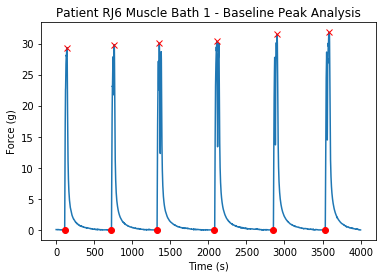

saved as: peakanalysisgraph_patientRJ6_bath1_baseline.pdf
contraction baseline forces: [0. 0. 0. 0. 0. 0.]
contraction peak forces: [29.31160591 29.80179378 30.07023012 30.36680698 31.46121073 31.8147714 ]
(array([501., 531., 584., 719., 589., 450.]), array([0., 0., 0., 0., 0., 0.]), array([ 110.,  726., 1325., 2071., 2852., 3535.]), array([ 611., 1257., 1909., 2790., 3441., 3985.]))
Muscle Bath 2
303 303.0
732 732.0
1125 1125.0
1378 1378.0
1803 1803.0
2250 2250.0
2699 2699.0
3055 3055.0
3450 3450.0
3901 3901.181804719837


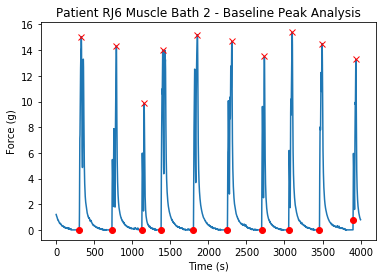

saved as: peakanalysisgraph_patientRJ6_bath2_baseline.pdf
contraction baseline forces: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.79044349]
contraction peak forces: [15.04659341 14.31828893  9.84628742 14.02101331 15.20741502 14.67583244
 13.50665777 15.39530775 14.51495812 13.28338537]
(array([322.        , 354.        , 193.        , 324.        ,
       364.        , 349.        , 272.        , 341.        ,
       353.        ,  97.81819528]), array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.79044349]), array([ 303.        ,  732.        , 1125.        , 1378.        ,
       1803.        , 2250.        , 2699.        , 3055.        ,
       3450.        , 3901.18180472]), array([ 625., 1086., 1318., 1702., 2167., 2599., 2971., 3396., 3803.,
       3999.]))
Muscle Bath 3
566 566.0
1331 1331.0
2163 2163.0
2962 2962.0
3898 3898.4601869604985


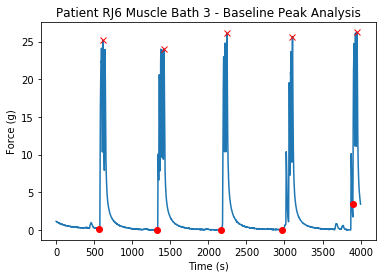

saved as: peakanalysisgraph_patientRJ6_bath3_baseline.pdf
contraction baseline forces: [1.53714010e-01 0.00000000e+00 0.00000000e+00 2.88084693e-03
 3.42026032e+00]
contraction peak forces: [25.17060081 24.02262062 26.10130094 25.64706681 26.23724759]
(array([ 437.54587631,  748.        , 1664.        ,  864.8150508 ,
        100.53981304]), array([1.53714010e-01, 0.00000000e+00, 0.00000000e+00, 2.88084693e-03,
       3.42026032e+00]), array([ 566.        , 1331.        , 2163.        , 2962.        ,
       3898.46018696]), array([1003.54587631, 2079.        , 3827.        , 3826.8150508 ,
       3999.        ]))
Muscle Bath 4
443 443.0
990 990.0
1547 1547.0
2051 2051.0
2579 2579.0
3154 3154.0
3559 3559.0


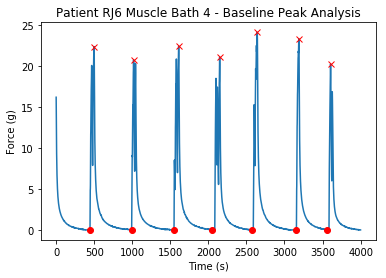

saved as: peakanalysisgraph_patientRJ6_bath4_baseline.pdf
contraction baseline forces: [0.         0.         0.         0.01289621 0.         0.
 0.00353893]
contraction peak forces: [22.3772106  20.77886496 22.43658391 21.11895344 24.13267571 23.33881569
 20.26200351]
(array([ 541.        ,  512.        , 1009.        ,  491.87816083,
        500.        ,  827.        ,  421.45902441]), array([0.        , 0.        , 0.        , 0.01289621, 0.        ,
       0.        , 0.00353893]), array([ 443.,  990., 1547., 2051., 2579., 3154., 3559.]), array([ 984.        , 1502.        , 2556.        , 2542.87816083,
       3079.        , 3981.        , 3980.45902441]))
Muscle Bath 5
24 24.0
831 831.0
1694 1694.0
2600 2600.0
3644 3644.051503906061


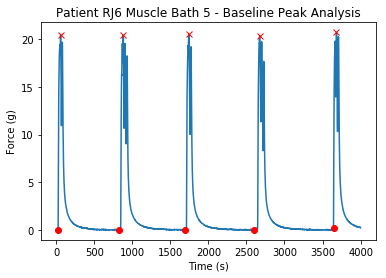

saved as: peakanalysisgraph_patientRJ6_bath5_baseline.pdf
contraction baseline forces: [0.         0.         0.         0.         0.23368111]
contraction peak forces: [20.43741027 20.41950197 20.50163124 20.3575216  20.72297514]
(array([661.        , 705.        , 769.        , 804.        ,
       354.94849609]), array([0.        , 0.        , 0.        , 0.        , 0.23368111]), array([  24.        ,  831.        , 1694.        , 2600.        ,
       3644.05150391]), array([ 685., 1536., 2463., 3404., 3999.]))
Muscle Bath 6
1150 1150.0
2385 2385.0
3346 3346.0


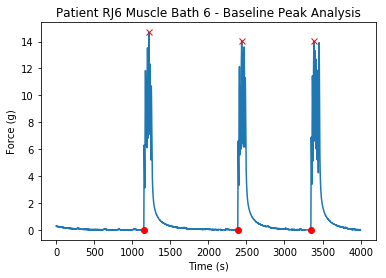

saved as: peakanalysisgraph_patientRJ6_bath6_baseline.pdf
contraction baseline forces: [0. 0. 0.]
contraction peak forces: [14.68803464 14.06806769 14.00438698]
(array([960., 772., 624.]), array([0., 0., 0.]), array([1150., 2385., 3346.]), array([2110., 3157., 3970.]))
Muscle Bath 7
213 213.0
690 690.0
1220 1220.0
1910 1910.0
2451 2451.0
3038 3038.0
3651 3651.058169843671


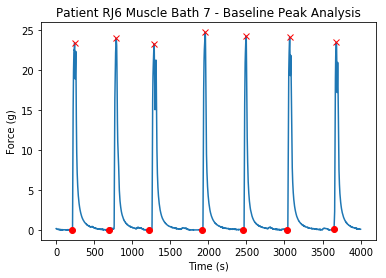

saved as: peakanalysisgraph_patientRJ6_bath7_baseline.pdf
contraction baseline forces: [0.         0.         0.         0.         0.00747664 0.00247701
 0.07208176]
contraction peak forces: [23.44956267 24.00886749 23.29738565 24.75942378 24.27152101 24.16194481
 23.49896697]
(array([ 463.        ,  499.        ,  556.        , 1684.        ,
        586.37108304,  555.186288  ,  346.94183016]), array([0.        , 0.        , 0.        , 0.        , 0.00747664,
       0.00247701, 0.07208176]), array([ 213.        ,  690.        , 1220.        , 1910.        ,
       2451.        , 3038.        , 3651.05816984]), array([ 676.        , 1189.        , 1776.        , 3594.        ,
       3037.37108304, 3593.186288  , 3998.        ]))
Muscle Bath 8
116 116.0
425 425.00000000000006
834 834.0
1152 1152.0
1557 1557.0
1904 1904.0
2266 2266.0
2631 2631.0491472469025
2631 2631.0
3395 3395.0
3848 3848.6048027745032


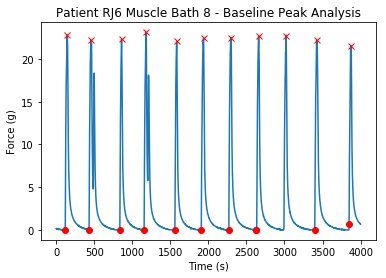

saved as: peakanalysisgraph_patientRJ6_bath8_baseline.pdf
contraction baseline forces: [0.         0.01956841 0.         0.         0.         0.
 0.         0.00083214 0.         0.         0.67862888]
contraction peak forces: [22.79625212 22.20990643 22.30850704 23.12449127 22.0763836  22.40790932
 22.47258886 22.65134375 22.74348128 22.2145083  21.55772455]
(array([672.        , 355.05035584, 286.        , 353.        ,
       301.        , 326.        , 338.        , 329.95085275,
       719.        , 402.        , 150.39519723]), array([0.        , 0.01956841, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00083214, 0.        , 0.        ,
       0.67862888]), array([ 116.        ,  425.        ,  834.        , 1152.        ,
       1557.        , 1904.        , 2266.        , 2631.04914725,
       2631.        , 3395.        , 3848.60480277]), array([ 788.        ,  780.05035584, 1120.        , 1505.        ,
       1858.        , 2230.        , 2604.       

In [49]:
#contraction baseline force determination, peak analysis graphs

#create list for contraction baseline forces
base = []
#loop through muscle baths 
for mb in range(len(df_ref)):
    #determine bath number
    bath = df_ref.iloc[mb]["Bath Number"]
    print("Muscle Bath",bath)
    #create figure to plot on
    f = plt.figure()
    #plot baseline force data for each muscle bath
    plt.plot(np.array(baseline_array_list[mb]))
    #label plot
    plt.title("Patient "+list(df_ref['Patient'])[mb]+" Muscle Bath "+str(bath)+" - Baseline Peak Analysis")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    #use peak_widths function to determine the widths of contractions
    widths = peak_widths(baseline_array_list[mb],locmax_indx_list[mb],rel_height = peak_rel_height)
    #create storage list for contraction baseline force
    storagelist = []
    #loop through each contraction, use info stored in widths variable
    #from the peak_widths function to determine the left baseline force 
    for contract_num in range(len(locmax_indx_list[mb])):
        #determine left baseline indx
        left_basex = int(widths[2][contract_num])
        print(left_basex,widths[2][contract_num])
        #determine left baseline force
        #left_basey = np.array(baseline_array_list[mb])[left_basex]
        #use interpolated width height
        left_basey = widths[1][contract_num]
        #plot left baseline force on plot
        plt.plot(left_basex,left_basey,'ro')
        #store this muscle baths contraction baseline forces
        storagelist.append(left_basey)
    #loop through contraction peaks and plot the maximum
    for counter, peak in enumerate(locmax_list[mb]):
        plt.plot(locmax_indx_list[mb][counter],peak,'rx')
    plt.show()
    #save plots as pdf
    savestring = "peakanalysisgraph_" + "patient"+(list(df_ref['Patient'])[mb])+"_"+"bath"+str(bath)+"_baseline"+'.pdf'
    print("saved as:",savestring)
    f.savefig('baseline_graphs/'+savestring,sep = '')
    #store contraction baseline forces
    base.append(np.array(storagelist))
    print("contraction baseline forces:",base[mb])
    print("contraction peak forces:",locmax_list[mb])
    print(widths)

#### Peak Force Amplitude & Peak Force Amplitude Corrected to CSA

In [50]:
#baseline peak force calculations

#create an empty list to store raw forces and titles
raw_force_list = []
forcetitles = []
#calculate baseline peak forces
for x in range(len(locmax_list)):
    #create a temporary list to store values for each muscle bath
    templist = []
    bath = df_ref.iloc[x]["Bath Number"]
    title = "bath" + str(bath) +" force (g)"
    forcetitles.append(title)
    for contract in range(len(locmax_list[x])):
        amp = (locmax_list[x][contract]-base[x][contract])
        #2 decimal places
        amp = float("%.2f" % amp)
        templist.append(amp)
    raw_force_list.append(np.array(templist))
    print("raw forces:",raw_force_list[x])
#make a dictionary out of titles and raw forces    
rawforcedic = dict(zip(forcetitles, raw_force_list))
#for each muscle bath calculate the average raw peak value during baseline
#this will be used for treatment peak normalization
#create empty storage lists 
basepeakmean = []
#for loop calculation 
for bath in range(len(raw_force_list)):
    basepeakmean.append(raw_force_list[bath].mean())  
#calculate cross-sectional area (CSA)
CSA_list = []
for bath in df_ref['Bath Number']:
    length = float(df_ref[df_ref['Bath Number']== bath]['Length (mm)'])
    mass = float(df_ref[df_ref['Bath Number']== bath]['Mass (mg)'])   
    CSA = ((mass*.001)/(1.056*length*.1)) * 100       #CSA in mm2
    CSA_list.append(CSA)
print("CSA:",(CSA_list))
#create an empty list to store CSA normalized forces and titles
norm_force_list = []
normtitles = []
#calculate CSA normalized baseline peak forces
for x in range(len(locmax_list)):
    #create a temporary list to store values for each muscle bath
    templist = []
    bath = df_ref.iloc[x]["Bath Number"]
    title = "bath" + str(bath) +" norm. to CSA (g/mm2)"
    normtitles.append(title)
    for contraction in range(len(locmax_list[x])):
        norm = ((locmax_list[x][contraction]-base[x][contraction])/CSA_list[x])
        norm = float("%.2f" % norm)
        templist.append(norm)
    norm_force_list.append(np.array(templist))
    print("corrected to CSA:",norm_force_list[x])
#make a dictionary out of titles and raw forces    
normforcedic = dict(zip(normtitles, norm_force_list))


raw forces: [29.31 29.8  30.07 30.37 31.46 31.81]
raw forces: [15.05 14.32  9.85 14.02 15.21 14.68 13.51 15.4  14.51 12.49]
raw forces: [25.02 24.02 26.1  25.64 22.82]
raw forces: [22.38 20.78 22.44 21.11 24.13 23.34 20.26]
raw forces: [20.44 20.42 20.5  20.36 20.49]
raw forces: [14.69 14.07 14.  ]
raw forces: [23.45 24.01 23.3  24.76 24.26 24.16 23.43]
raw forces: [22.8  22.19 22.31 23.12 22.08 22.41 22.47 22.65 22.74 22.21 20.88]
CSA: [2.6065707853521856, 2.702767634057274, 3.899286987522281, 2.0986497949950516, 2.3437081480687847, 1.1222552842191669, 2.150676387723939, 4.066261291694818]
corrected to CSA: [11.25 11.43 11.54 11.65 12.07 12.21]
corrected to CSA: [5.57 5.3  3.64 5.19 5.63 5.43 5.   5.7  5.37 4.62]
corrected to CSA: [6.42 6.16 6.69 6.58 5.85]
corrected to CSA: [10.66  9.9  10.69 10.06 11.5  11.12  9.65]
corrected to CSA: [8.72 8.71 8.75 8.69 8.74]
corrected to CSA: [13.09 12.54 12.48]
corrected to CSA: [10.9  11.16 10.83 11.51 11.28 11.23 10.89]
corrected to CSA: [5.61 

#### Contraction Durations

C:\Users\Weston\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: PeakPropertyWarning: some peaks have a prominence of 0
  app.launch_new_instance()
C:\Users\Weston\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: PeakPropertyWarning: some peaks have a width of 0
  app.launch_new_instance()


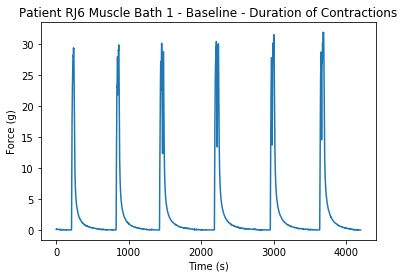

saved as: contractduration_patientRJ6_bath1_baseline.pdf
peak durations: [1 0 0 0 0 1]


IndexError: index 10 is out of bounds for axis 0 with size 10

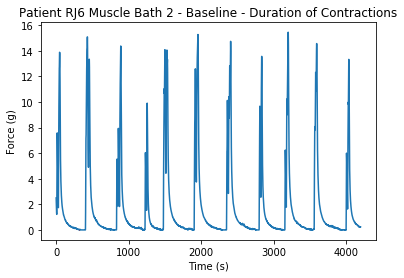

In [68]:
#calculate duration of contractions
peakduration = []
base_duration_titles = []
for mb in range(len(baseline_array_list)):
    bath = df_ref.iloc[mb]["Bath Number"]
    title = "bath" + str(bath) +" duration times (s)"
    base_duration_titles.append(title)
    templist = []
    #create figure to plot on
    f = plt.figure()
    plt.plot(np.array(baseline_array_list[mb]))
    #label plot
    plt.title("Patient "+list(df_ref['Patient'])[mb]+" Muscle Bath "+str(bath)+" - Baseline - Duration of Contractions")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    widths = peak_widths(baseline_array_list[mb],locmax_indx_list[mb],rel_height=rel_height)
    for contraction in range(len(locmax_list[mb])):
        leftx = ((widths[2][contraction]))
        rightx = ((widths[3][contraction]))
        templist.append(int(rightx-leftx))
        plt.hlines(*widths[1:], color="C3")
    plt.show()
    peakduration.append(np.array(templist))
    #save plots as pdf
    savestring = "contractduration_" + "patient"+(list(df_ref['Patient'])[mb])+"_"+"bath"+str(bath)+"_baseline"+'.pdf'
    print("saved as:",savestring)
    print("peak durations:",peakduration[mb])
    f.savefig('baseline_graphs/'+savestring,sep = '')
#make a dictionary for baseline contractions duration time    
base_contract_dur_time = dict(zip(base_duration_titles,peakduration))

#### Relaxation Time

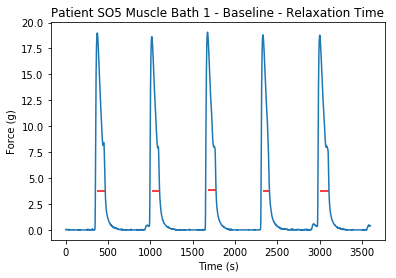

saved as: relaxtime_patientSO5_bath1_baseline.pdf
relax times: [ 93  92 100  75 109]


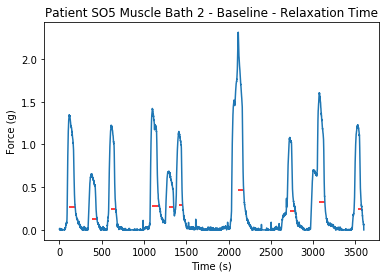

saved as: relaxtime_patientSO5_bath2_baseline.pdf
relax times: [70 59 54 79 58 45 63 63 66 47]


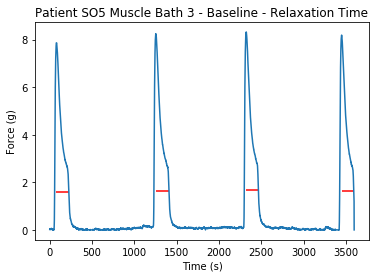

saved as: relaxtime_patientSO5_bath3_baseline.pdf
relax times: [145 155 142 143]


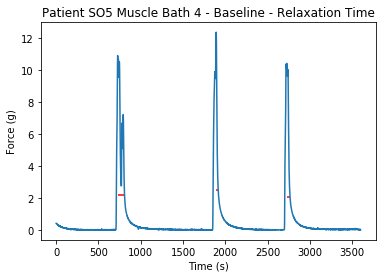

saved as: relaxtime_patientSO5_bath4_baseline.pdf
relax times: [81 24 38]


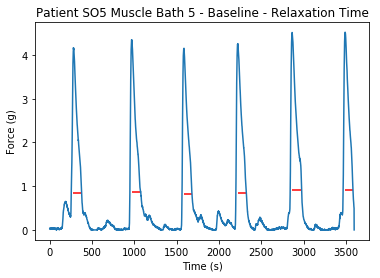

saved as: relaxtime_patientSO5_bath5_baseline.pdf
relax times: [ 95 107  93  99 112  93]


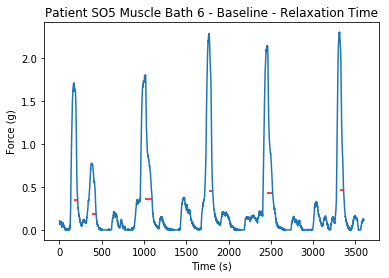

saved as: relaxtime_patientSO5_bath6_baseline.pdf
relax times: [44 53 79 42 65 48]


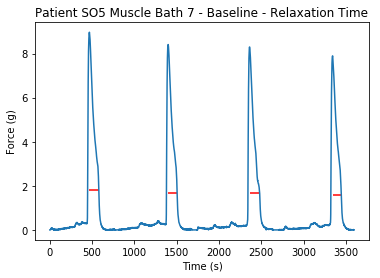

saved as: relaxtime_patientSO5_bath7_baseline.pdf
relax times: [111 105 118 102]


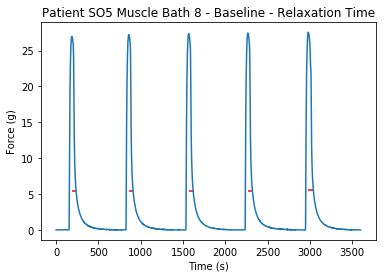

saved as: relaxtime_patientSO5_bath8_baseline.pdf
relax times: [48 49 52 53 59]


In [95]:
#relaxation time
relaxtitle = []
relax_time = []
for mb in range(len(baseline_array_list)):
    bath = df_ref.iloc[mb]["Bath Number"]
    title = "bath" + str(bath) +" relaxation times (s)"
    relaxtitle.append(title)
    widths = peak_widths(baseline_array_list[mb],locmax_indx_list[mb],rel_height=rel_height)
    relax = widths[3]-locmax_indx_list[mb]
    relax = relax.astype(int)
    relax_time.append(relax)
    #create figure to plot on
    f = plt.figure()
    plt.plot(np.array(baseline_array_list[mb]))
    #label plot
    plt.title("Patient "+list(df_ref['Patient'])[mb]+" Muscle Bath "+str(bath)+" - Baseline - Relaxation Time")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    for contract_num in range(len(locmax_indx_list[mb])):
        #determine left baseline indx
        right_basex = int(widths[3][contract_num])
        #determine left baseline force
        #right_basey = np.array(baseline_array_list[mb])[right_basex]
        right_basey = widths[1][contract_num]
        #plot left baseline force on plot
        plt.hlines(right_basey,locmax_indx_list[mb][contract_num],right_basex, colors= 'r')
    plt.show()
    #save plots as pdf
    savestring = "relaxtime_" + "patient"+(list(df_ref['Patient'])[mb])+"_"+"bath"+str(bath)+"_baseline"+'.pdf'
    print("saved as:",savestring)
    f.savefig('baseline_graphs/'+savestring,sep = '')
    print("relax times:",relax_time[mb])
#make a dictionary for baseline contractions duration time    
base_relax_time = dict(zip(relaxtitle,relax_time))

#### Baseline Excel Spreadsheet

In [96]:
#sending baseline data to Excel spreadsheet

#create a dataframe to store raw force data
df_raw = pd.DataFrame.from_dict(rawforcedic, orient='index')
df_raw = df_raw.transpose()
#create a dataframe to store normalized data
df_norm = pd.DataFrame.from_dict(normforcedic, orient='index')
df_norm = df_norm.transpose()
#create a dataframe to store contraction duration time data
df_base_contract_dur = pd.DataFrame.from_dict(base_contract_dur_time, orient='index')
df_base_contract_dur = df_base_contract_dur.transpose()
#create a dataframe to store contraction relaxation time data
df_base_relax = pd.DataFrame.from_dict(base_relax_time, orient='index')
df_base_relax = df_base_relax.transpose()
#create output baseline dataframe
df_base_out = df_raw.join(df_norm)
df_base_out = df_base_out.join(df_base_contract_dur)
df_base_out = df_base_out.join(df_base_relax)
print(df_base_out.head())
#determine which set of muscle baths were used
if df_ref["Bath Number"].max() > 16:
    computer = "comp3"
elif df_ref["Bath Number"].max() < 9:
    computer = "comp1"
else: 
    computer = "comp2"
#write baseline dataframe to Excel spreadsheet
#assume tissue in set of 8 muscle baths comes from the 
#same patient 
base_out_file = "Patient"+ list(df_ref['Patient'])[0] +"_baseline_"+computer+".xlsx"
df_base_out.to_excel('baseline_output_files/'+base_out_file)
print("saved as:",base_out_file)

   bath1 force (g)  bath2 force (g)  bath3 force (g)  bath4 force (g)  \
0            18.99             1.35             7.86            10.88   
1            18.64             0.66             8.25            12.34   
2            19.07             1.23             8.31            10.40   
3            18.81             1.42             8.19              NaN   
4            18.78             0.52              NaN              NaN   

   bath5 force (g)  bath6 force (g)  bath7 force (g)  bath8 force (g)  \
0             4.17             1.71             8.96            26.98   
1             4.35             0.73             8.41            27.24   
2             4.15             1.80             8.30            27.37   
3             4.26             2.28             7.89            27.45   
4             4.51             2.14              NaN            27.56   

   bath1 norm. to CSA (g/mm2)  bath2 norm. to CSA (g/mm2)  \
0                        5.66                        0.32   


## 1 HOUR TREATMENT

#### Treatment Graphs

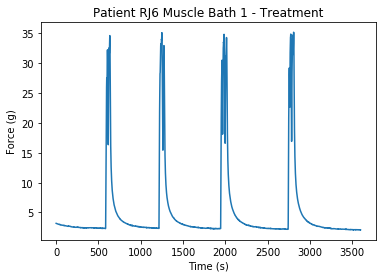

patientRJ6_bath1_treatment.pdf


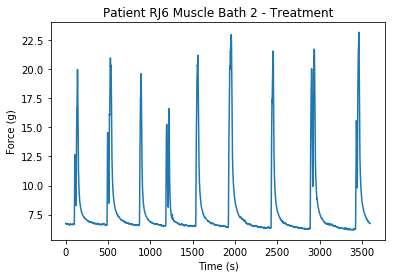

patientRJ6_bath2_treatment.pdf


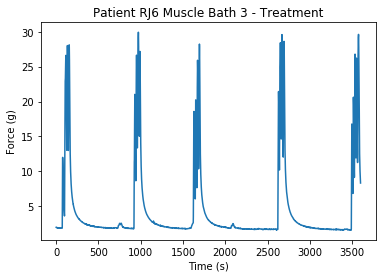

patientRJ6_bath3_treatment.pdf


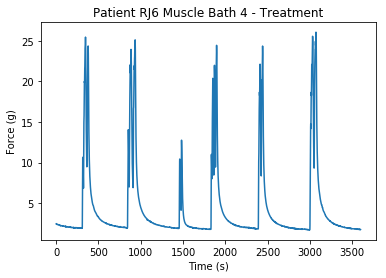

patientRJ6_bath4_treatment.pdf


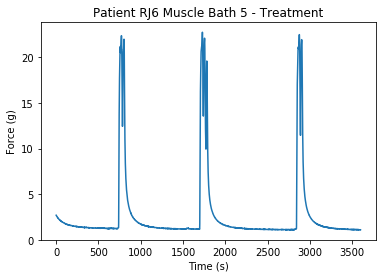

patientRJ6_bath5_treatment.pdf


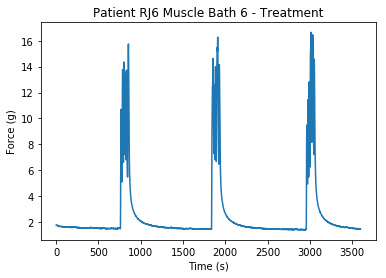

patientRJ6_bath6_treatment.pdf


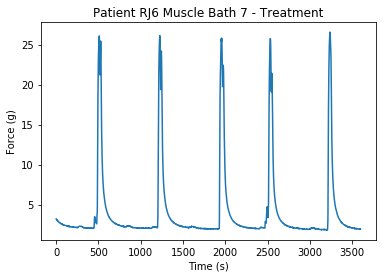

patientRJ6_bath7_treatment.pdf


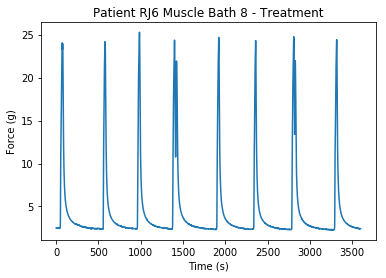

patientRJ6_bath8_treatment.pdf


In [120]:
#create a placeholder list for storing arrays of treatment force data
treat_array_list = []
#loop through viable muscle baths in study file (df_file) and retrieve treatment force data
#send array of each muscle bath treatment force data to treat_array_list
count = 0
for bath in df_ref['Bath Number']:
    if bath < 9:
        treatment_array = (df_file.loc[treat_time_list[count]:treat_time_list[count]+3599,Force_list[bath-1]])  
    elif bath > 16: 
        treatment_array = (df_file.loc[treat_time_list[count]:treat_time_list[count]+3599,Force_list[bath-17]])
    else:
        treatment_array = (df_file.loc[treat_time_list[count]:treat_time_list[count]+3599,Force_list[bath-9]])
    treat_array_list.append(treatment_array)
    count += 1
#plot the treatment contraction force data
for i in range(len(treat_array_list)):        
    bath = df_ref.iloc[i]["Bath Number"]
    #print("Muscle Bath",bath)
    f = plt.figure()
    plt.plot(np.array(treat_array_list[i]))
    plt.title("Patient "+list(df_ref['Patient'])[i]+" Muscle Bath "+str(bath)+" - Treatment")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    plt.show()
    savestring = "patient"+(list(df_ref['Patient'])[i])+"_"+"bath"+str(bath)+"_treatment"+'.pdf'
    print(savestring)
    f.savefig('treatment_graphs/'+savestring,sep = '')

In [121]:
len(treat_array_list[0]),len(treat_array_list[1])
#len(treat_array_list[2]),len(treat_array_list[3])

(3600, 3600)

#### Offset Baseline Force to 0g

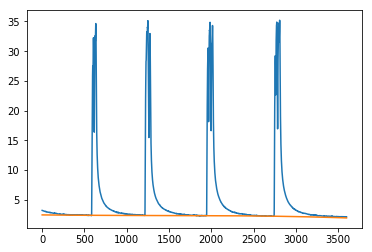

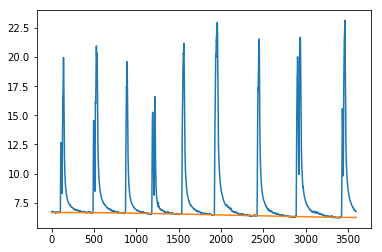

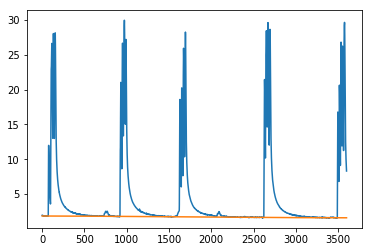

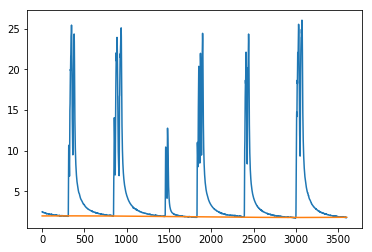

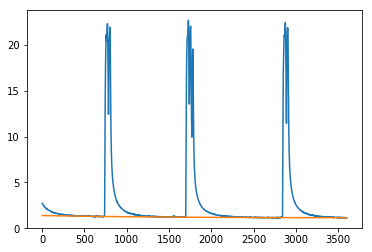

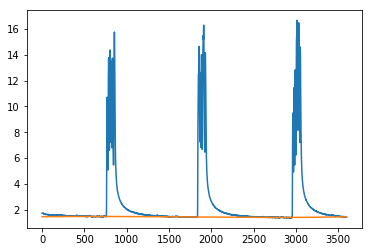

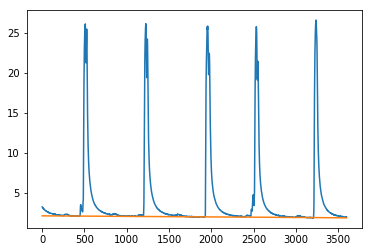

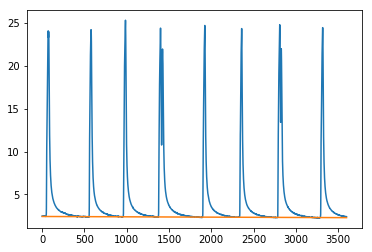

In [122]:
#plot muscle bath baseline contractions; overlay baseline/passive tension
for mb in range(len(treat_array_list)):
    treat_array_list[mb] = (np.array(treat_array_list[mb]))
    plt.plot((treat_array_list[mb]))
    plt.plot(peakutils.baseline(np.array(treat_array_list[mb])))
    plt.show()

#edge clipping

#treat_array_list[0][3500:] = peakutils.baseline(np.array(treat_array_list[0]))[3500:]
#treat_array_list[3][0:500] = peakutils.baseline(np.array(treat_array_list[3]))[0:500]
#treat_array_list[5][-1] = peakutils.baseline(np.array(treat_array_list[5]))[1800]

In [123]:
type(treat_array_list)

list

In [124]:
type(treat_array_list[0])

numpy.ndarray

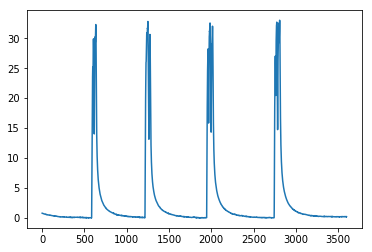

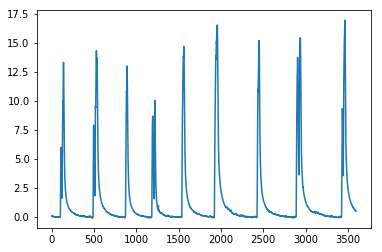

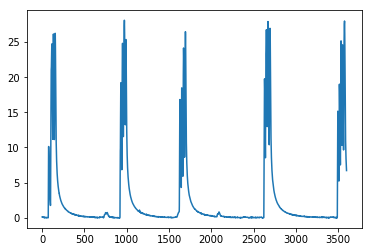

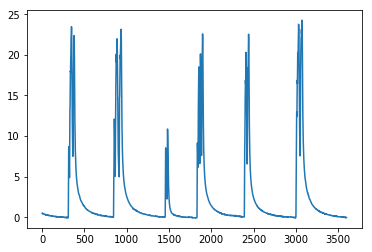

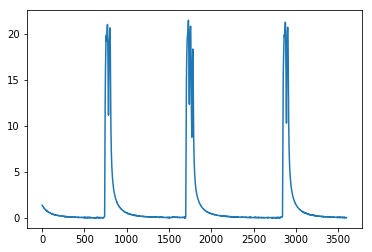

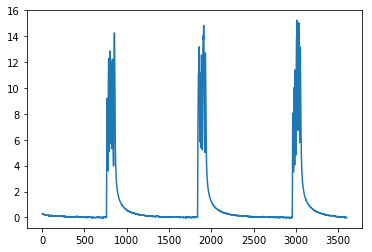

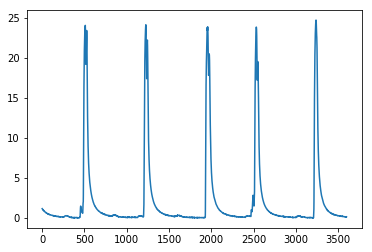

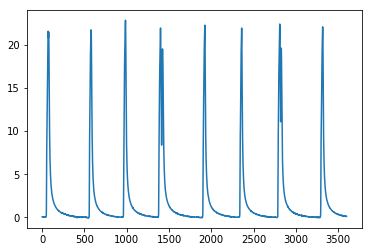

In [125]:
for mb in range(len(treat_array_list)):
    treat_array_list[mb] = treat_array_list[mb] - peakutils.baseline(np.array(treat_array_list[mb]))
    plt.plot(treat_array_list[mb])
    plt.show()

In [126]:
for mb in range(len(treat_array_list)):
    treat_array_list[mb] = treat_array_list[mb].clip(min=0)
    print(treat_array_list[mb])

[0.75904145 0.75322019 0.7583987  ... 0.1670973  0.19658402 0.18007114]
[0.08205879 0.0800417  0.09102479 ... 0.5356031  0.52666701 0.51873079]
[0.09301077 0.0830358  0.07406092 ... 7.1721387  6.92215214 6.70316549]
[0.49441124 0.48036105 0.47431105 ... 0.         0.         0.        ]
[1.34515859e+00 1.31732695e+00 1.32149522e+00 ... 4.67446469e-03
 6.94978848e-04 0.00000000e+00]
[0.2789308  0.26985057 0.2727705  ... 0.01024444 0.         0.        ]
[1.11685829 1.08493604 1.07501377 ... 0.07448293 0.0705832  0.0876835 ]
[0.04977756 0.04580868 0.04583981 ... 0.09300299 0.0970279  0.10605279]


#### Process Edges

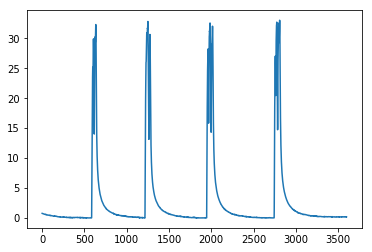

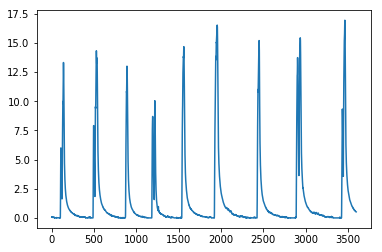

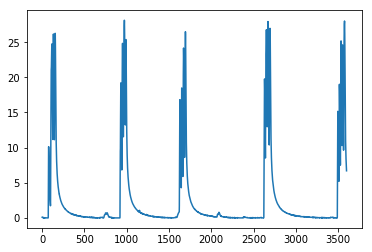

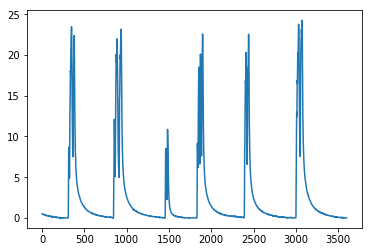

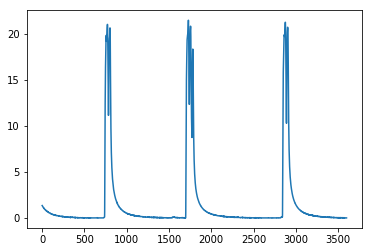

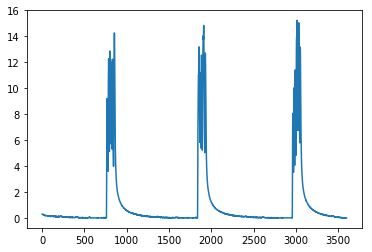

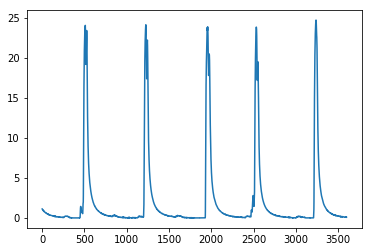

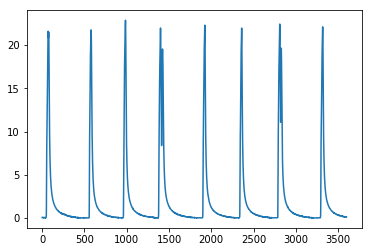

In [127]:
#treat_array_list[1][-1] = 0

for mb in range(len(treat_array_list)):
    plt.plot(treat_array_list[mb])
    plt.show()

#### Find Peaks

In [128]:
treatment_width_var=5

In [129]:
#peak analysis for 1 hour treatment
#create storage lists for outputs
treat_locmax_list = []
fp_treat_output_list = []
#for loop for peak analysis
#reuse the width variable defined earlier for baseline peak analysis
for i in range(len(treat_array_list)):           
    bath = df_ref.iloc[i]["Bath Number"]
    #comment out for automatic peak detection
    #print("Muscle Bath",bath,":")
    #print 90% peak level
    #print("25% of peak",max(treat_array_list[i]) - ((max(treat_array_list[i])-min(treat_array_list[i]))*.75))
    #input the height cut off for peak analysis
    #cutoff = float(input("input peak height cutoff:"))
    #automatically determine peak cutoff height 
    peak25 = max(treat_array_list[i][1:-1]) - ((max(treat_array_list[i][1:-1])-min(treat_array_list[i][1:-1]))*.75)
    cutoff = float(peak25)
    #vary width variable for each study to tune the find_peaks function
    #comment out width_var unless need to vary width for each bath
    #width_var = float(input("input the width variable for find_peaks function:"))
    fp_output = find_peaks(np.array(treat_array_list[(i)]),height = cutoff, width = treatment_width_var,distance = 100)
    locmax = np.array(treat_array_list[(i)])[fp_output[0]]
    treat_locmax_list.append(locmax)
    fp_treat_output_list.append(fp_output)
    #print(fp_output)
    #print("\n")


In [130]:
#processing find_peaks output
#assigning values from find peaks output to a list of local max indices 
locmax_indx_treat_list = []
for i in range(len(fp_treat_output_list)):
    locmax_indx_treat_list.append(fp_treat_output_list[i][0])
#assigning values from find peaks dictionary ouput to a list (to later be used with calculating duration of contractions, relaxation time, etc.)
locmax_dic_treat_list = []
for i in range(len(fp_treat_output_list)):
    locmax_dic_treat_list.append(fp_treat_output_list[i][1])
    

#### Peak Analysis Graphs

Muscle Bath 1


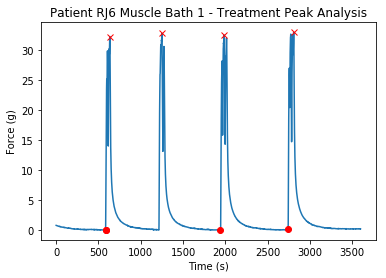

saved as: peakanalysisgraph_patientRJ6_bath1_treatment.pdf
peak forces: [32.30382568 32.81819658 32.5647538  33.02396724]
contraction baseline forces: [0.01525286 0.         0.         0.13783485]
Muscle Bath 2


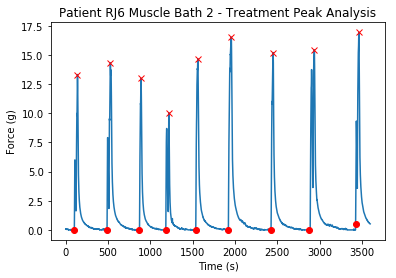

saved as: peakanalysisgraph_patientRJ6_bath2_treatment.pdf
peak forces: [13.31840588 14.32343836 13.00617459 10.04791718 14.68001485 16.52619045
 15.20030308 15.43445418 16.94297685]
contraction baseline forces: [0.         0.         0.         0.         0.         0.
 0.         0.         0.51873079]
Muscle Bath 3


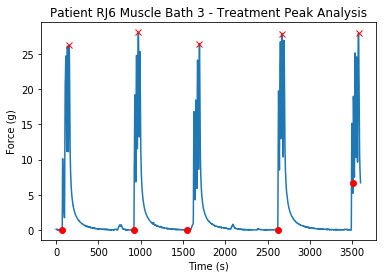

saved as: peakanalysisgraph_patientRJ6_bath3_treatment.pdf
peak forces: [26.26082043 28.12236499 26.48908503 27.93741795 28.01182038]
contraction baseline forces: [0.         0.         0.         0.         6.70316549]
Muscle Bath 4


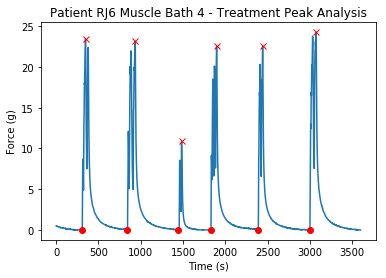

saved as: peakanalysisgraph_patientRJ6_bath4_treatment.pdf
peak forces: [23.46566166 23.15315294 10.86540615 22.57993841 22.5401116  24.26386968]
contraction baseline forces: [0.         0.00813795 0.00305436 0.         0.03709116 0.        ]
Muscle Bath 5


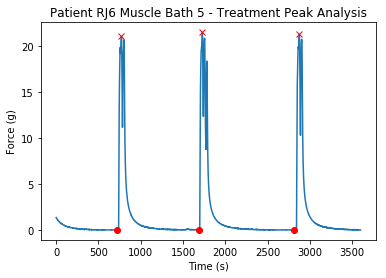

saved as: peakanalysisgraph_patientRJ6_bath5_treatment.pdf
peak forces: [21.04316011 21.50012205 21.28253909]
contraction baseline forces: [0. 0. 0.]
Muscle Bath 6


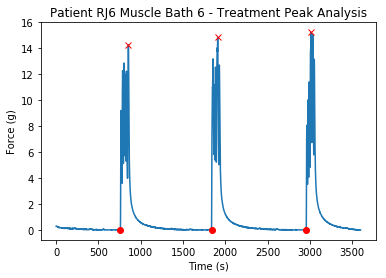

saved as: peakanalysisgraph_patientRJ6_bath6_treatment.pdf
peak forces: [14.2653866  14.84620717 15.24590715]
contraction baseline forces: [0. 0. 0.]
Muscle Bath 7


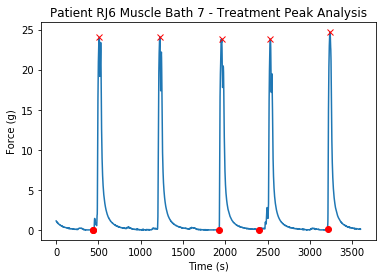

saved as: peakanalysisgraph_patientRJ6_bath7_treatment.pdf
peak forces: [24.01758924 24.09243882 23.83622984 23.80372909 24.65889599]
contraction baseline forces: [0.0030905  0.         0.         0.01988283 0.0705832 ]
Muscle Bath 8


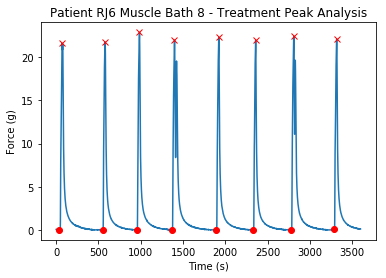

saved as: peakanalysisgraph_patientRJ6_bath8_treatment.pdf
peak forces: [21.60302274 21.76092299 22.87710516 21.97453384 22.30698583 21.96512502
 22.43250972 22.1093474 ]
contraction baseline forces: [0.00890689 0.         0.         0.         0.         0.
 0.         0.09282813]


In [131]:
#contraction baseline force determination, peak analysis graphs

#create a list for contration baseline forces
base_treat = []
#loop through muscle baths
for mb in range(len(df_ref)):
    #determine bath number
    bath = df_ref.iloc[mb]["Bath Number"]
    print("Muscle Bath",bath)
    #create figure to plot on
    f = plt.figure()
    #plot baseline force data for each muscle bath
    plt.plot(np.array(treat_array_list[mb]))
    #label plot
    plt.title("Patient "+list(df_ref['Patient'])[mb]+" Muscle Bath "+str(bath)+" - Treatment Peak Analysis")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    #use peak_widths function to determine the widths of contractions
    widths = peak_widths(treat_array_list[mb],locmax_indx_treat_list[mb],rel_height=peak_rel_height)
    #create storage list for contraction baseline force
    storagelist = []
    #loop through each contraction, use info stored in widths variable
    #from the peak_widths function to determine the left baseline force 
    for contract_num in range(len(locmax_indx_treat_list[mb])):
        #determine left baseline indx
        left_basex = int(widths[2][contract_num])
        #determine left baseline force
        #left_basey = np.array(treat_array_list[mb])[left_basex]
        #use interpolated y position
        left_basey = widths[1][contract_num]
        #plot left baseline force on plot
        plt.plot(left_basex,left_basey,'ro')
        #store this muscle baths contraction baseline forces
        storagelist.append(left_basey)
        #loop through contraction peaks and plot the maximum
    for counter, peak in enumerate(treat_locmax_list[mb]):
        plt.plot(locmax_indx_treat_list[mb][counter],peak,'rx')
    plt.show()
    #save plots as pdf
    savestring = "peakanalysisgraph_" + "patient"+(list(df_ref['Patient'])[mb])+"_"+"bath"+str(bath)+"_treatment"+'.pdf'
    print("saved as:",savestring)
    f.savefig('treatment_graphs/'+savestring,sep = '')
    #store contraction baseline forces
    base_treat.append(np.array(storagelist))
    print("peak forces:",treat_locmax_list[mb])
    print("contraction baseline forces:",base_treat[mb])   

#### Peak Force Amplitude & Peak Force Amplitude Corrected to CSA

In [49]:
#treatment peak force calculations
#create an empty list to store the raw treatment peak values
treatpeakvals = []
treatpeaktitles = []
#calculate treatment peak forces
for mb in range(len(treat_locmax_list)):
    #create a temporary list to store each contraction peak for current muscle bath
    templist = []
    for contraction in range(len(treat_locmax_list[mb])):
        amplitude = (treat_locmax_list[mb][contraction]-base_treat[mb][contraction])
        amplitude = float("%.2f" % amplitude)
        templist.append(amplitude)
    treatpeakvals.append(np.array(templist))
    print("contraction amp:",treatpeakvals[mb])
    #create a title for these values. store them in a list 
    bath = df_ref.iloc[mb]["Bath Number"]
    title = "bath" + str(bath) +" force (g)"
    treatpeaktitles.append(title)
#normalizing to baseline function
#create an empty list to store the normalized treatment peak values and titles
normalized_treatment_peaks = []
normtreatpeaktitles = []
#normalize forces to baseline average peak force
for mb in range(len(treatpeakvals)):
    peaks_norm_2_base_function = treatpeakvals[mb]/basepeakmean[mb]
    normalized_treatment_peaks.append(peaks_norm_2_base_function)
    print("norm to baseline function:",normalized_treatment_peaks)
    #normalized treatment peaks titles (for column labels in Excel file)
    bath = df_ref.iloc[mb]["Bath Number"]
    title = "bath" + str(bath) +" norm. to baseline function"
    normtreatpeaktitles.append(title)
#normalize forces to CSA    
#create an empty list to store CSA normalized forces and titles
forces_norm_2_CSA_list= []
norm_2_CSA_titles = []
#calculate CSA normalized baseline peak forces
for mb in range(len(treat_locmax_list)):
    #create a temporary list to store values for each muscle bath
    templist = []
    bath = df_ref.iloc[mb]["Bath Number"]
    title = "bath" + str(bath) +" norm. to CSA (g/mm2)"
    norm_2_CSA_titles.append(title)
    for contraction in range(len(treat_locmax_list[mb])):
        norm = ((treat_locmax_list[mb][contraction]-base_treat[mb][contraction])/CSA_list[mb])
        norm = float("%.2f" % norm)
        templist.append(norm)
    forces_norm_2_CSA_list.append(np.array(templist))  
    print("norm to CSA:",forces_norm_2_CSA_list)
#make a dictionary out of titles and raw treatment contraction peaks    
treatpeakdic = dict(zip(treatpeaktitles, treatpeakvals))
#make a dictionary out of titles and normalized treatment contraction peaks
treatnormpeakdic = dict(zip(normtreatpeaktitles, normalized_treatment_peaks))
#make a dictionary out of titles and treatment contraction peaks normalized to CSA
norm2CSA_dic = dict(zip(norm_2_CSA_titles,forces_norm_2_CSA_list))

contraction amp: [19.08 18.95 18.99 19.04 19.05]
contraction amp: [1.93 1.31 1.6  1.23 1.56 1.06 2.76]
contraction amp: [8.26 8.27 8.47]
contraction amp: [12.8  13.24 15.08 13.89]
contraction amp: [4.54 4.53 4.6  4.5  4.66]
contraction amp: [2.54 2.27 2.17 2.05 1.85 0.12]
contraction amp: [7.73 7.36 6.93 6.24]
contraction amp: [27.85 27.83 27.75 27.8  27.77]
norm to baseline function: [array([1.01177219, 1.00487857, 1.00699968, 1.00965108, 1.01018136])]
norm to baseline function: [array([1.01177219, 1.00487857, 1.00699968, 1.00965108, 1.01018136]), array([1.55394525, 1.0547504 , 1.28824477, 0.99033816, 1.25603865,
       0.85346216, 2.22222222])]
norm to baseline function: [array([1.01177219, 1.00487857, 1.00699968, 1.00965108, 1.01018136]), array([1.55394525, 1.0547504 , 1.28824477, 0.99033816, 1.25603865,
       0.85346216, 2.22222222]), array([1.04722662, 1.04849445, 1.07385103])]
norm to baseline function: [array([1.01177219, 1.00487857, 1.00699968, 1.00965108, 1.01018136]), array(

#### Contraction Durations

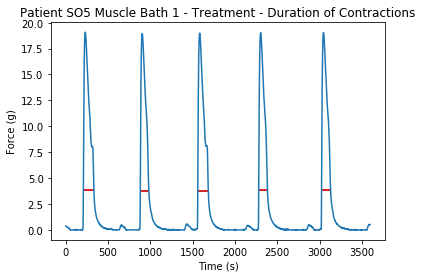

saved as: contractduration_patientSO5_bath1_treatment.pdf
contraction durations: [124 101 124 103 106]


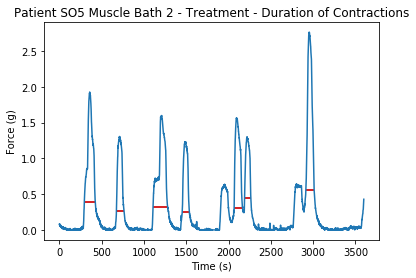

saved as: contractduration_patientSO5_bath2_treatment.pdf
contraction durations: [129  91 172  84 100  72  98]


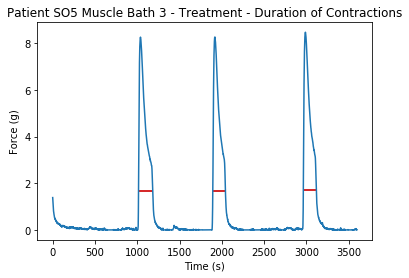

saved as: contractduration_patientSO5_bath3_treatment.pdf
contraction durations: [167 149 152]


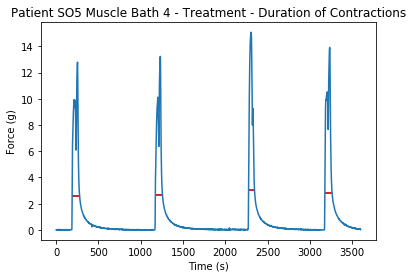

saved as: contractduration_patientSO5_bath4_treatment.pdf
contraction durations: [88 85 70 86]


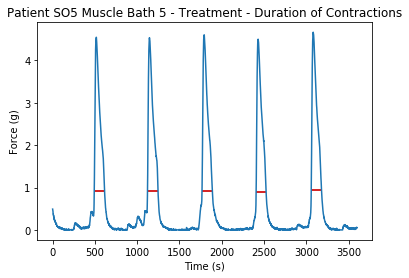

saved as: contractduration_patientSO5_bath5_treatment.pdf
contraction durations: [122 124 122 117 121]


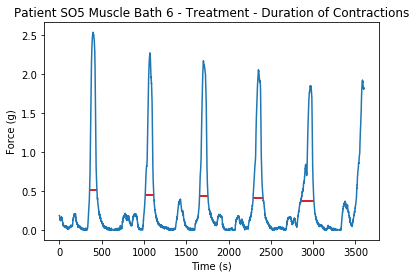

saved as: contractduration_patientSO5_bath6_treatment.pdf
contraction durations: [ 87 100  99 119 155  17]


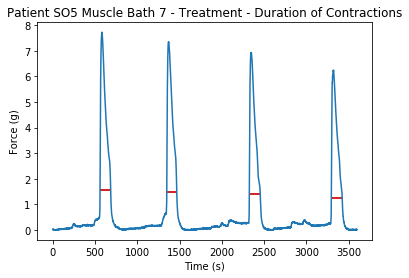

saved as: contractduration_patientSO5_bath7_treatment.pdf
contraction durations: [125 117 128 128]


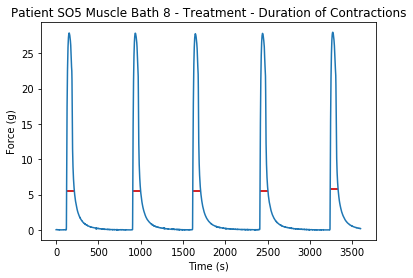

saved as: contractduration_patientSO5_bath8_treatment.pdf
contraction durations: [91 92 92 93 93]


In [50]:
#calculate duration of contractions
peakduration = []
treat_duration_titles = []
for mb in range(len(treat_array_list)):
    bath = df_ref.iloc[mb]["Bath Number"]
    title = "bath" + str(bath) +" duration times (s)"
    treat_duration_titles.append(title)
    templist = []
    #create figure to plot on
    f = plt.figure()
    plt.plot(np.array(treat_array_list[mb]))
    #label plot
    plt.title("Patient "+list(df_ref['Patient'])[mb]+" Muscle Bath "+str(bath)+" - Treatment - Duration of Contractions")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    widths = peak_widths(treat_array_list[mb],locmax_indx_treat_list[mb],rel_height=rel_height)
    for contraction in range(len(treat_locmax_list[mb])):
        leftx = ((widths[2][contraction]))
        rightx = ((widths[3][contraction]))
        templist.append(int(rightx-leftx))
        plt.hlines(*widths[1:], color="C3")
    plt.show()
    peakduration.append(np.array(templist))
    #save plots as pdf
    savestring = "contractduration_" + "patient"+(list(df_ref['Patient'])[mb])+"_"+"bath"+str(bath)+"_treatment"+'.pdf'
    print("saved as:",savestring)
    f.savefig('treatment_graphs/'+savestring,sep = '')
    print("contraction durations:",peakduration[mb])
#make a dictionary for treatment contractions duration time    
treat_contract_dur_time = dict(zip(treat_duration_titles,peakduration))

#### Relaxation Time

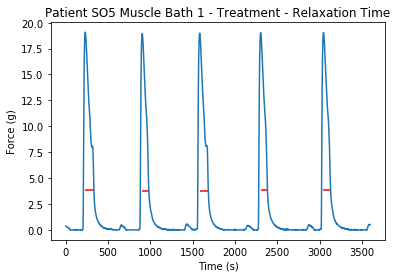

saved as: relaxtime_patientSO5_bath1_treatment.pdf
relaxation times: [101  77 101  80  84]


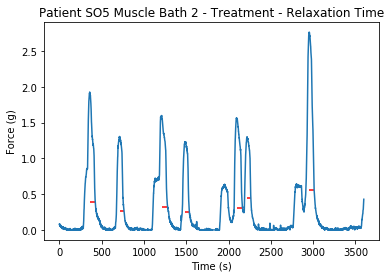

saved as: relaxtime_patientSO5_bath2_treatment.pdf
relaxation times: [66 54 71 52 72 43 60]


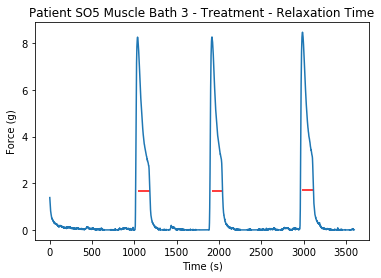

saved as: relaxtime_patientSO5_bath3_treatment.pdf
relaxation times: [143 124 129]


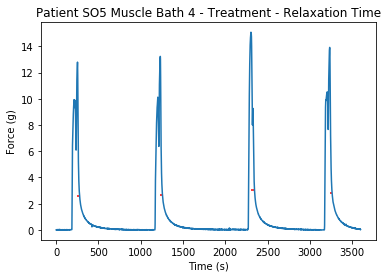

saved as: relaxtime_patientSO5_bath4_treatment.pdf
relaxation times: [25 26 42 28]


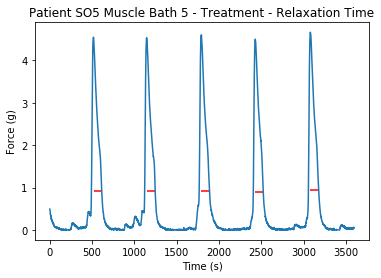

saved as: relaxtime_patientSO5_bath5_treatment.pdf
relaxation times: [ 97 101  96  94  98]


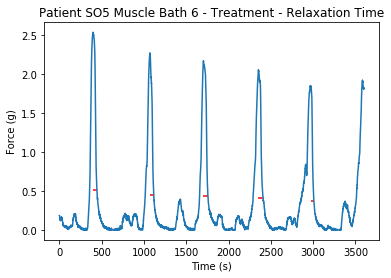

saved as: relaxtime_patientSO5_bath6_treatment.pdf
relaxation times: [47 45 53 55 37  9]


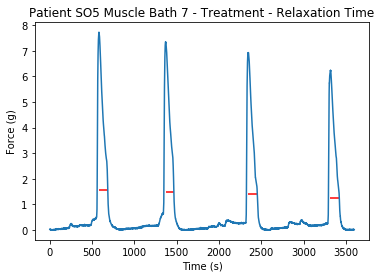

saved as: relaxtime_patientSO5_bath7_treatment.pdf
relaxation times: [104  97 105 104]


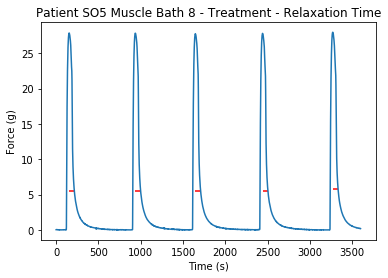

saved as: relaxtime_patientSO5_bath8_treatment.pdf
relaxation times: [61 63 61 63 63]


In [51]:
#relaxation time 
relaxtitle = []
relax_time = []
for mb in range(len(treat_array_list)):
    bath = df_ref.iloc[mb]["Bath Number"]
    title = "bath" + str(bath) +" relaxation times (s)"
    relaxtitle.append(title)
    widths = peak_widths(treat_array_list[mb],locmax_indx_treat_list[mb],rel_height=rel_height)
    relax = widths[3]-locmax_indx_treat_list[mb]
    relax = relax.astype(int)
    relax_time.append(relax)
    #create figure to plon on
    f = plt.figure()
    plt.plot(np.array(treat_array_list[mb]))
    #label plot
    plt.title("Patient "+list(df_ref['Patient'])[mb]+" Muscle Bath "+str(bath)+" - Treatment - Relaxation Time")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    for contract_num in range(len(locmax_indx_treat_list[mb])):
        right_basex = int(widths[3][contract_num])
        #right_basey = np.array(treat_array_list[mb])[right_basex]
        right_basey = widths[1][contract_num]
        plt.hlines(right_basey,locmax_indx_treat_list[mb][contract_num],right_basex, colors= 'r')
    plt.show()  
    #save plots as pdf
    savestring = "relaxtime_" + "patient"+(list(df_ref['Patient'])[mb])+"_"+"bath"+str(bath)+"_treatment"+'.pdf'
    print("saved as:",savestring)
    f.savefig('treatment_graphs/'+savestring,sep = '')
    print("relaxation times:",relax_time[mb])
#make a dictionary for treatment relaxation time    
treat_relax_time = dict(zip(relaxtitle,relax_time))

In [52]:
#export treatment peak data to Excel spreadsheet
#create a dataframe to store raw force data
df_t_raw = pd.DataFrame.from_dict(treatpeakdic, orient='index')
df_t_raw = df_t_raw.transpose()
#create a dataframe to store normalized data
df_t_norm = pd.DataFrame.from_dict(treatnormpeakdic, orient='index')
df_t_norm = df_t_norm.transpose()
#create a dataframe to store normalized to CSA data
df_t_norm2CSA = pd.DataFrame.from_dict(norm2CSA_dic, orient='index')
df_t_norm2CSA = df_t_norm2CSA.transpose()
#create a dataframe to store contraction duration time data
df_treat_contract_dur = pd.DataFrame.from_dict(treat_contract_dur_time, orient='index')
df_treat_contract_dur = df_treat_contract_dur.transpose()
#create a dataframe to store contraction relaxation time data
df_treat_relax = pd.DataFrame.from_dict(treat_relax_time, orient='index')
df_treat_relax = df_treat_relax.transpose()
#create output baseline dataframe
df_treat_out = df_t_raw.join(df_t_norm)
df_treat_out = df_treat_out.join(df_t_norm2CSA)
df_treat_out = df_treat_out.join(df_treat_contract_dur)
df_treat_out = df_treat_out.join(df_treat_relax)
print(df_treat_out.head())
#determine which set of muscle baths were used
if df_ref["Bath Number"].max() > 16:
    computer = "comp3"
elif df_ref["Bath Number"].max() < 9:
    computer = "comp1"
else: 
    computer = "comp2"
#write baseline dataframe to Excel spreadsheet
#assume tissue in set of 8 muscle baths comes from the 
#same patient 
treat_out_file = "Patient"+ list(df_ref['Patient'])[0] +"_treatment_"+computer+".xlsx"
df_treat_out.to_excel('treatment_output_files/'+treat_out_file)
print(treat_out_file)

   bath1 force (g)  bath2 force (g)  bath3 force (g)  bath4 force (g)  \
0            19.08             1.93             8.26            12.80   
1            18.95             1.31             8.27            13.24   
2            18.99             1.60             8.47            15.08   
3            19.04             1.23              NaN            13.89   
4            19.05             1.56              NaN              NaN   

   bath5 force (g)  bath6 force (g)  bath7 force (g)  bath8 force (g)  \
0             4.54             2.54             7.73            27.85   
1             4.53             2.27             7.36            27.83   
2             4.60             2.17             6.93            27.75   
3             4.50             2.05             6.24            27.80   
4             4.66             1.85              NaN            27.77   

   bath1 norm. to baseline function  bath2 norm. to baseline function  \
0                          1.011772              

In [53]:
#4 parameters
#1. peak force or amplitude
#2. frequency or contractions/hour
#3. duration of contractions
#4. relaxation time

In [54]:
comments_file.close()